In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.datasets.dblp import DBLP
import random
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

Train DBLP

In [2]:
 #https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_conv_dblp.py
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)


class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])


model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device =  'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1]
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)
Epoch: 010, Loss: 0.2003, Train: 0.9875, Val: 0.7850, Test: 0.8253
Epoch: 020, Loss: 0.0019, Train: 1.0000, Val: 0.7925, Test: 0.8262
Epoch: 030, Loss: 0.0026, Train: 1.0000, Val: 0.8025, Test: 0.8274
Epoch: 040, Loss: 0.0043, Train: 1.0000, Val: 0.8075, Test: 0.8235
Epoch: 050, Loss: 0.0041, Train: 1.0000, Val: 0.7925, Test: 0.8182
Epoch: 060, Loss: 0.0038, Train: 1.0000, Val: 0.7925, Test: 0.8179
Epoch: 070, Loss: 0.0034, Train: 1.0000, Val: 0.8050, Test: 0.8155


Graph (without node features) generated from HGEN

In [3]:
G = nx.read_gexf("DBLP_four_area_hgen.gexf")

Adding node features to graph

importing Jupyter notebook from dblp_gmm_features.ipynb
no of class author0 node samples - 1150
no of class author1 node samples - 1150
no of class author2 node samples - 1150
no of class author3 node samples - 1151
no of class paper node samples - 2988
no of class term node samples - 3646


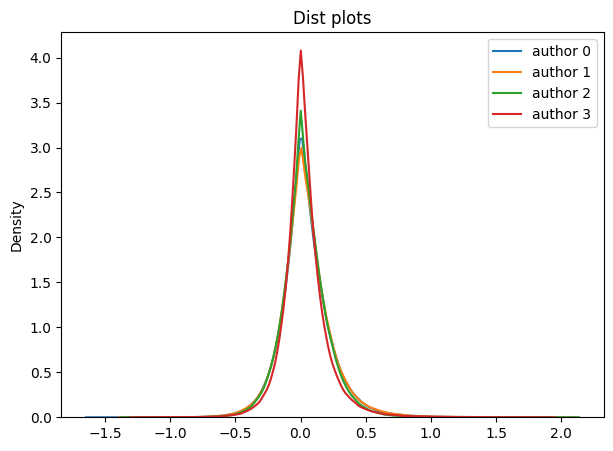

In [4]:
#Load node features 
import import_ipynb
import dblp_gmm_features

In [5]:
author_node_features = dblp_gmm_features.author_node_features
paper_node_features = dblp_gmm_features.paper_node_features
term_node_features = dblp_gmm_features.term_node_features
conf_nodes = dblp_gmm_features.conf_nodes

In [6]:
 #Adding node degree
for node in G.nodes():
    d = G.degree(node)
    G.nodes[node]["degree"] = d

In [7]:
#Generate graphs of 2-hop neighbourhood
def graph_gen(nodeid):
    
    num_hops = 2  
    nodes = []
    edges = []
    #Get small graph nodes
    nodes = nx.single_source_shortest_path_length(G, nodeid, cutoff=num_hops).keys() 
    if 3 <= len(nodes) <= 50:
        graph = nx.ego_graph(G,nodeid, num_hops, center=True,undirected = True)
        #Get small graph edges
        edges = [e for e in graph.edges]
        #nx.draw(graph, with_labels = True)
        #plt.show()
        #print('nodeid',nodeid)
        #print('node count',len(nodes))
        #print('edge count',len(edges))
        return nodes, edges
    else:
        return None, None

In [8]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [9]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [11]:
all_edges = {}

In [12]:
def create_dataset(nodes,edges,author_node_features,paper_node_features,term_node_features,conf_nodes,node_id):
    
    author_df = author_node_features[author_node_features["nodeId"].isin([int(x) for x in nodes])]
    paper_df = paper_node_features[paper_node_features["nodeId"].isin([int(x) for x in nodes])]
    term_df = term_node_features[term_node_features["nodeId"].isin([int(x) for x in nodes])]
    conf_df = conf_nodes[conf_nodes["nodeId"].isin([int(x) for x in nodes])] 
    
    #Nodes   
    author = np.asarray(author_df.drop(columns=['nodeId','class']))
    paper = np.asarray(paper_df.drop(columns=['nodeId']))
    term = np.asarray(term_df.drop(columns=['nodeId']))
    
    x_author = torch.tensor(author).to(dtype=torch.float32)
    y_author = torch.tensor(np.array(author_df["class"]), dtype=torch.long)
    x_paper = torch.tensor(paper).to(dtype=torch.float32)
    x_term = torch.tensor(term).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))
    
    author_to_paper = []
    paper_to_author = []
    paper_to_term = []
    paper_to_conf = []
    term_to_paper = []
    conf_to_paper = []
    remaining_edges = []
   
    for i in range(len(edges)):

        if (int(source[i]) in list(author_df['nodeId'])) and (int(dest[i]) in list(paper_df['nodeId'])):
            author_to_paper.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(paper_df['nodeId'])) and (int(dest[i]) in list(author_df['nodeId'])):
            paper_to_author.append((int(source[i]),int(dest[i]))) 

        elif (int(source[i]) in list(paper_df['nodeId'])) and (int(dest[i]) in list(term_df['nodeId'])):     
            paper_to_term.append((int(source[i]),int(dest[i]))) 

        elif (int(source[i]) in list(paper_df['nodeId'])) and (int(dest[i]) in list(conf_df['nodeId'])):
             paper_to_conf.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(term_df['nodeId'])) and (int(dest[i]) in list(paper_df['nodeId'])):
            term_to_paper.append((int(source[i]),int(dest[i]))) 

        elif (int(source[i]) in list(conf_df['nodeId'])) and (int(dest[i]) in list(paper_df['nodeId'])):
            conf_to_paper.append((int(source[i]),int(dest[i]))) 
        else:
            remaining_edges.append((int(source[i]),int(dest[i])))
    
    
    all_edges[node_id] = [*author_to_paper,*paper_to_author,*paper_to_term,*paper_to_conf,*term_to_paper,
                          *conf_to_paper]
               
    #Re-map indices to correct range
    author_nodes_mapping = remap_indices(list(author_df["nodeId"]))
    paper_nodes_mapping = remap_indices(list(paper_df["nodeId"]))
    term_nodes_mapping = remap_indices(list(term_df["nodeId"]))
    conf_nodes_mapping = remap_indices(list(conf_df["nodeId"]))
    
    node_list = {}
    for d in [author_nodes_mapping, paper_nodes_mapping, term_nodes_mapping,conf_nodes_mapping]:
        node_list.update(d)
    
    #Create Hetero Data      
    small_graph = HeteroData({'author':{'x': x_author, 'y':y_author}, 'paper':{'x': x_paper},'term':{'x': x_term},
                   'conference':{'num_nodes': conf_df.shape[0]}})
    
    if author_to_paper:
        edge_index_author_paper = preprocess_edges(author_to_paper,node_list)
        small_graph['author','to','paper'].edge_index = edge_index_author_paper
    
    if paper_to_author:
        edge_index_paper_author = preprocess_edges(paper_to_author,node_list)
        small_graph['paper','to','author'].edge_index = edge_index_paper_author

    if paper_to_term:
        edge_index_paper_term = preprocess_edges(paper_to_term,node_list)
        small_graph['paper','to','term'].edge_index = edge_index_paper_term

    if paper_to_conf:
        edge_index_paper_conf = preprocess_edges(paper_to_conf,node_list) 
        small_graph['paper','to','conference'].edge_index = edge_index_paper_conf

    if term_to_paper:
        edge_index_term_paper = preprocess_edges(term_to_paper,node_list) 
        small_graph['term','to','paper'].edge_index = edge_index_term_paper

    if conf_to_paper:
        edge_index_conf_paper = preprocess_edges(conf_to_paper,node_list)
        small_graph['conference','to','paper'].edge_index = edge_index_conf_paper
        
  
    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
    
    return small_graph

In [13]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['author'].test_mask
        correct = (pred[mask] == small_graph['author'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['author'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        #print(correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list

In [14]:
node_subset = dict((n,d['degree']) for n,d in G.nodes().items() if d['degree']>=2)
n_list= random.sample(node_subset.keys(), 4000)

In [15]:
softmax_dict = {}
nodefeature_dict = {}
for nodeid in n_list: 
    #Generate small Graphs
    nodes, edges = graph_gen(nodeid)
    if not (nodes is None):
        
        small_graph_data = create_dataset(nodes,edges,
                              author_node_features,paper_node_features,
                              term_node_features,conf_nodes,nodeid)
        
        edge_list = all_edges[nodeid]
        graph = nx.Graph(edge_list)
        if not nx.is_empty(graph) and nx.is_connected(graph):

            if (small_graph_data['author'].x.nelement()!=0) and \
            (small_graph_data['paper','to','author']) and \
            (small_graph_data['author','to','paper']) and \
            (small_graph_data['paper','to','conference']) and \
            (small_graph_data['paper','to','term']):

                print('nodeid',nodeid)
                #print('node count',len(nodes))
                print('node count',small_graph_data.num_nodes)
                #print('edge count',len(edges))
                print('edge count',small_graph_data.num_edges)

                #graph = nx.ego_graph(G,nodeid, 2, center=True,undirected = True)
                #nx.draw(graph, with_labels = True)
                #plt.show() 

                #Evaluate trained DBLP on smaller graphs

                softmax = evaluate_gnn(small_graph_data)
                softmax_dict[nodeid] = softmax
                nodefeature_dict[nodeid]={'author':small_graph_data['author'].x,
                                         'paper':small_graph_data['paper'].x,
                                         'term':small_graph_data['term'].x}
                #print(small_graph_data)

            else:
                #print("The next graph could not be evaluated. Required edges are missing.")
                pass

    else:
        #print("The next graph could not be loaded. Node count is less than 3")
        pass
        

nodeid 5311
node count 37
edge count 48
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[17, 4231] },
  term={ x=[15, 50] },
  conference={
    num_nodes=3,
    x=[3, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 10] },
  (paper, to, conference)={ edge_index=[2, 16] },
  (term, to, paper)={ edge_index=[2, 11] },
  (conference, to, paper)={ edge_index=[2, 9] }
)
Prediction: tensor([0, 1])
Ground Truth: tensor([0, 1])
tensor([True, True])
tensor([[0.9598, 0.0043, 0.0062, 0.0297],
        [0.0926, 0.5981, 0.2457, 0.0635]])
------------------------------------------------------------------
nodeid 8021
node count 43
edge count 52
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[22, 4231] },
  term={ x=[15, 50] },
  conference={
    num_nodes=4,
    x=[4, 1

nodeid 8934
node count 27
edge count 28
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[6, 4231] },
  term={ x=[17, 50] },
  conference={
    num_nodes=2,
    x=[2, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 17] },
  (paper, to, conference)={ edge_index=[2, 5] },
  (term, to, paper)={ edge_index=[2, 2] },
  (conference, to, paper)={ edge_index=[2, 2] }
)
Prediction: tensor([2, 0])
Ground Truth: tensor([0, 0])
tensor([False,  True])
tensor([[0.0986, 0.1729, 0.5662, 0.1624],
        [0.6218, 0.1762, 0.1149, 0.0871]])
------------------------------------------------------------------
nodeid 10201
node count 44
edge count 54
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[16, 4231] },
  term={ x=[21, 50] },
  conference={
    num_nodes=5,
    x=[5, 1

nodeid 545
node count 7
edge count 6
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[2, 4231] },
  term={ x=[2, 50] },
  conference={
    num_nodes=1,
    x=[1, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 2] },
  (paper, to, term)={ edge_index=[2, 1] },
  (paper, to, conference)={ edge_index=[2, 1] },
  (term, to, paper)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 0])
Ground Truth: tensor([0, 0])
tensor([False,  True])
tensor([[2.3527e-01, 6.6198e-01, 1.0044e-01, 2.3133e-03],
        [9.5204e-01, 5.8260e-04, 4.7285e-02, 9.0497e-05]])
------------------------------------------------------------------
nodeid 1882
node count 23
edge count 28
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[16, 4231] },
  term={ x=[3, 50] },
  conference={
    num_nodes=2,
    x=[2, 1]
  },
  (author, to, pa

nodeid 9022
node count 27
edge count 31
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[10, 4231] },
  term={ x=[12, 50] },
  conference={
    num_nodes=3,
    x=[3, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 6] },
  (paper, to, conference)={ edge_index=[2, 6] },
  (term, to, paper)={ edge_index=[2, 12] },
  (conference, to, paper)={ edge_index=[2, 5] }
)
Prediction: tensor([0, 2])
Ground Truth: tensor([0, 1])
tensor([ True, False])
tensor([[0.4371, 0.1693, 0.2046, 0.1889],
        [0.0102, 0.4413, 0.4713, 0.0772]])
------------------------------------------------------------------
nodeid 8448
node count 36
edge count 41
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[13, 4231] },
  term={ x=[17, 50] },
  conference={
    num_nodes=4,
    x=[4, 1

nodeid 8781
node count 15
edge count 15
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[4, 4231] },
  term={ x=[7, 50] },
  conference={
    num_nodes=2,
    x=[2, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 4] },
  (paper, to, conference)={ edge_index=[2, 3] },
  (term, to, paper)={ edge_index=[2, 4] },
  (conference, to, paper)={ edge_index=[2, 2] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([2, 3])
tensor([ True, False])
tensor([[0.1701, 0.2549, 0.3877, 0.1873],
        [0.1805, 0.1522, 0.4933, 0.1740]])
------------------------------------------------------------------
nodeid 1050
node count 21
edge count 23
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[5, 4231] },
  term={ x=[10, 50] },
  conference={
    num_nodes=4,
    x=[4, 1]
  

nodeid 7740
node count 41
edge count 51
HeteroData(
  author={
    x=[3, 334],
    y=[3],
    train_mask=[3],
    val_mask=[3],
    test_mask=[3]
  },
  paper={ x=[13, 4231] },
  term={ x=[20, 50] },
  conference={
    num_nodes=5,
    x=[5, 1]
  },
  (author, to, paper)={ edge_index=[2, 2] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 17] },
  (paper, to, conference)={ edge_index=[2, 13] },
  (term, to, paper)={ edge_index=[2, 11] },
  (conference, to, paper)={ edge_index=[2, 7] }
)
Prediction: tensor([0, 0, 0])
Ground Truth: tensor([0, 0, 1])
tensor([ True,  True, False])
tensor([[7.0927e-01, 3.1286e-02, 2.4550e-01, 1.3941e-02],
        [6.1468e-01, 8.7136e-02, 2.2155e-01, 7.6636e-02],
        [9.2670e-01, 7.2775e-02, 5.2672e-04, 4.7767e-07]])
------------------------------------------------------------------
nodeid 9918
node count 31
edge count 34
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_m

nodeid 8965
node count 38
edge count 43
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[14, 4231] },
  term={ x=[19, 50] },
  conference={
    num_nodes=3,
    x=[3, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 11] },
  (paper, to, conference)={ edge_index=[2, 9] },
  (term, to, paper)={ edge_index=[2, 14] },
  (conference, to, paper)={ edge_index=[2, 7] }
)
Prediction: tensor([0, 0])
Ground Truth: tensor([0, 0])
tensor([True, True])
tensor([[0.6725, 0.0473, 0.1032, 0.1770],
        [0.6020, 0.1518, 0.2041, 0.0422]])
------------------------------------------------------------------
nodeid 7964
node count 44
edge count 51
HeteroData(
  author={
    x=[3, 334],
    y=[3],
    train_mask=[3],
    val_mask=[3],
    test_mask=[3]
  },
  paper={ x=[18, 4231] },
  term={ x=[20, 50] },
  conference={
    num_nodes=3,
    x=[3, 1]

nodeid 2855
node count 12
edge count 11
HeteroData(
  author={
    x=[1, 334],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1]
  },
  paper={ x=[5, 4231] },
  term={ x=[3, 50] },
  conference={
    num_nodes=3,
    x=[3, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 2] },
  (paper, to, conference)={ edge_index=[2, 5] },
  (term, to, paper)={ edge_index=[2, 1] },
  (conference, to, paper)={ edge_index=[2, 1] }
)
Prediction: tensor([2])
Ground Truth: tensor([2])
tensor([True])
tensor([[0.0339, 0.1906, 0.7109, 0.0646]])
------------------------------------------------------------------
nodeid 2465
node count 37
edge count 52
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[19, 4231] },
  term={ x=[13, 50] },
  conference={
    num_nodes=3,
    x=[3, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (pape

nodeid 155
node count 16
edge count 17
HeteroData(
  author={
    x=[2, 334],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  paper={ x=[4, 4231] },
  term={ x=[8, 50] },
  conference={
    num_nodes=2,
    x=[2, 1]
  },
  (author, to, paper)={ edge_index=[2, 2] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 4] },
  (paper, to, conference)={ edge_index=[2, 4] },
  (term, to, paper)={ edge_index=[2, 4] },
  (conference, to, paper)={ edge_index=[2, 2] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([0, 3])
tensor([False, False])
tensor([[0.0466, 0.2199, 0.5499, 0.1836],
        [0.3244, 0.1047, 0.3994, 0.1715]])
------------------------------------------------------------------
nodeid 8369
node count 34
edge count 39
HeteroData(
  author={
    x=[3, 334],
    y=[3],
    train_mask=[3],
    val_mask=[3],
    test_mask=[3]
  },
  paper={ x=[13, 4231] },
  term={ x=[15, 50] },
  conference={
    num_nodes=3,
    x=[3, 1]
  

In [16]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  87


In [17]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}
prob_class3_dict = {}
for nodeid in softmax_dict:
    

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []
        list3= []

        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 
            list3.append(prob[3])

     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:    
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:    
        prob_class2_dict[nodeid]=max(list2)
    if len(list3) != 0:    
        prob_class3_dict[nodeid]=max(list3)

Getting the highest prediction probability for each class of author node

In [18]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())
max_pred3 = max(prob_class3_dict.values())

In [19]:
# Getting nodeid to re-generate 2 hop graph which maximizes prediction
class0_nodeid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_nodeid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_nodeid = max(prob_class2_dict, key=prob_class2_dict.get)
class3_nodeid = max(prob_class3_dict, key=prob_class3_dict.get)

In [21]:
def plot_graph(nodeid, max_pred,nodetype,edges):

    classes = []
    graph = nx.Graph(edges)
    for g in graph.nodes():
        if g in list(author_node_features['nodeId']):
            classes.append(1)
        elif g in list(paper_node_features['nodeId']):
            classes.append(0)
        elif g in list(term_node_features['nodeId']):
            classes.append(2)
        elif g in list(conf_nodes['nodeId']):
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), classes)), 'class')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('nodeid for generating 2 hop graph: ',nodeid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in graph.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [22]:
#nodefeature_dict

Plotting explanation graph and node features for each class of author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  37
nodeid for generating 2 hop graph:  5311
Max pred probability for class 0 is 0.95979243516922


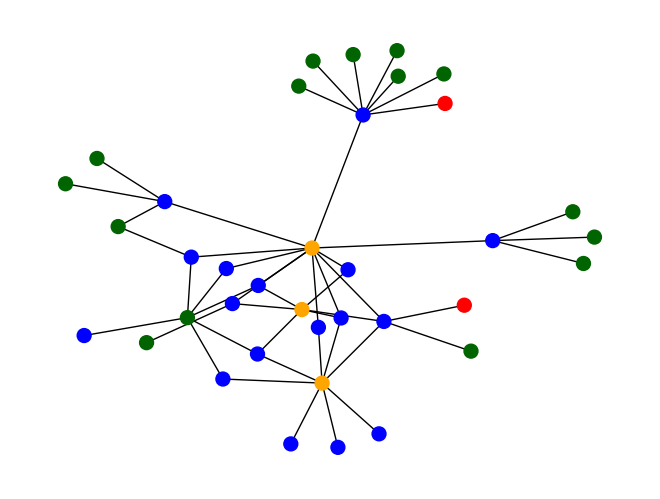

In [23]:
explanation_graph0 = plot_graph(class0_nodeid, max_pred0, 0, all_edges[class0_nodeid])

In [24]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [25]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=15)
    plt.xticks(fontsize=15)

    plt.yticks(fontsize=15)
    plt.xlabel('feature values',fontsize=15)
    plt.ylabel('feature count',fontsize=15)

    plt.show()



In [26]:
ind= index_2d(softmax_dict[class0_nodeid], max_pred0)[0]

In [27]:
list0= nodefeature_dict[class0_nodeid]['author'].numpy()[ind]

In [28]:
Counter(list0)

Counter({0.0: 328, 1.0: 6})

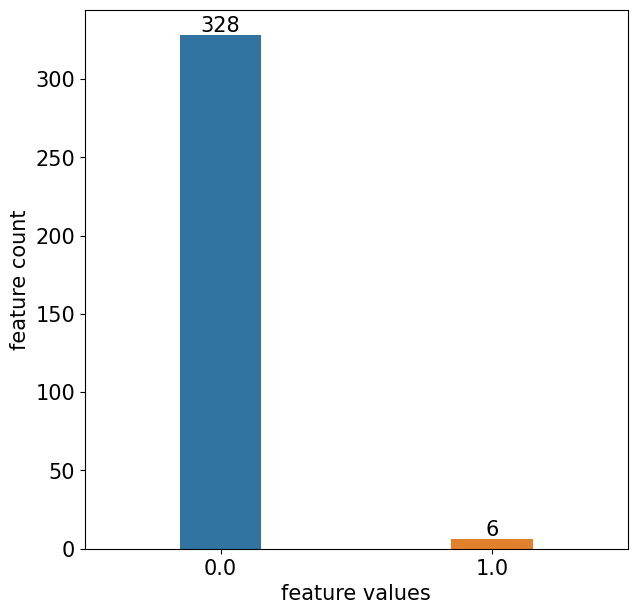

In [29]:
count_plot(list0)

Number of nodes:  29
nodeid for generating 2 hop graph:  8424
Max pred probability for class 1 is 0.9419769644737244


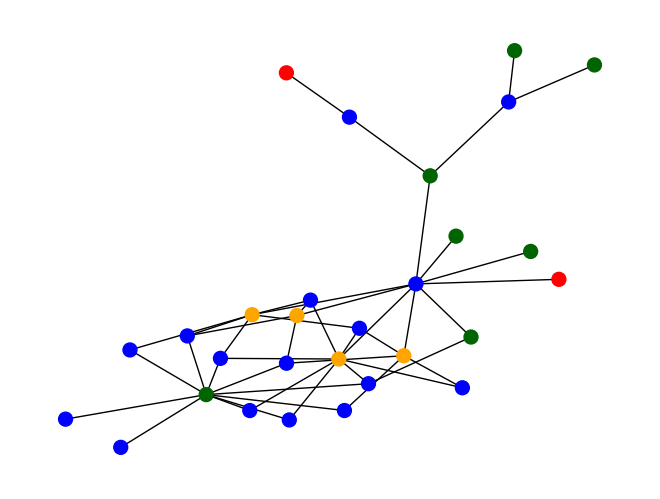

In [30]:
explanation_graph1 = plot_graph(class1_nodeid, max_pred1, 1,all_edges[class1_nodeid])

In [31]:
ind= index_2d(softmax_dict[class1_nodeid], max_pred1)[0]

In [32]:
list1= nodefeature_dict[class1_nodeid]['author'].numpy()[ind]

In [33]:
Counter(list1)

Counter({0.0: 333, 1.0: 1})

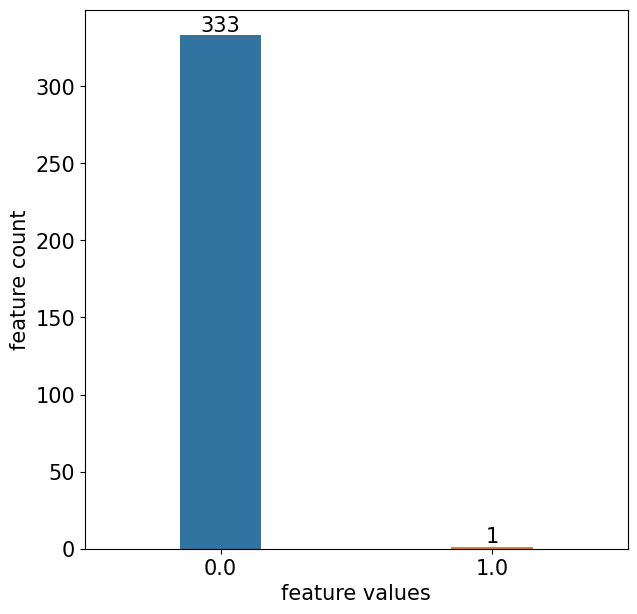

In [34]:
count_plot(list1)

Number of nodes:  19
nodeid for generating 2 hop graph:  10873
Max pred probability for class 2 is 0.9995866417884827


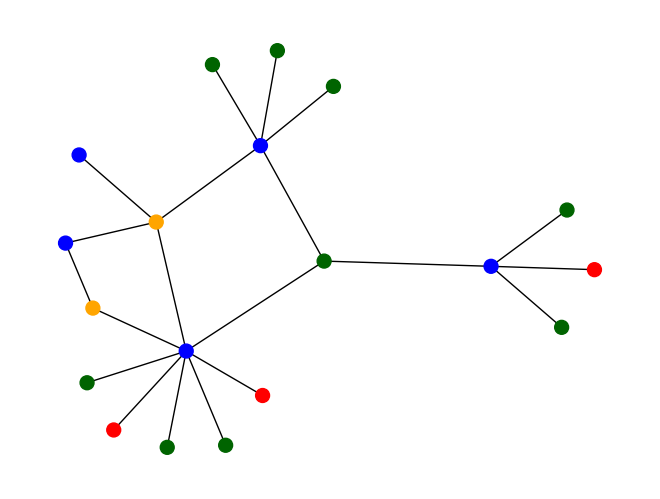

In [35]:
explanation_graph2 = plot_graph(class2_nodeid, max_pred2, 2,all_edges[class2_nodeid])

In [36]:
ind= index_2d(softmax_dict[class2_nodeid], max_pred2)[0]

In [37]:
list2= nodefeature_dict[class2_nodeid]['author'].numpy()[ind]

In [38]:
Counter(list2)

Counter({0.0: 333, 1.0: 1})

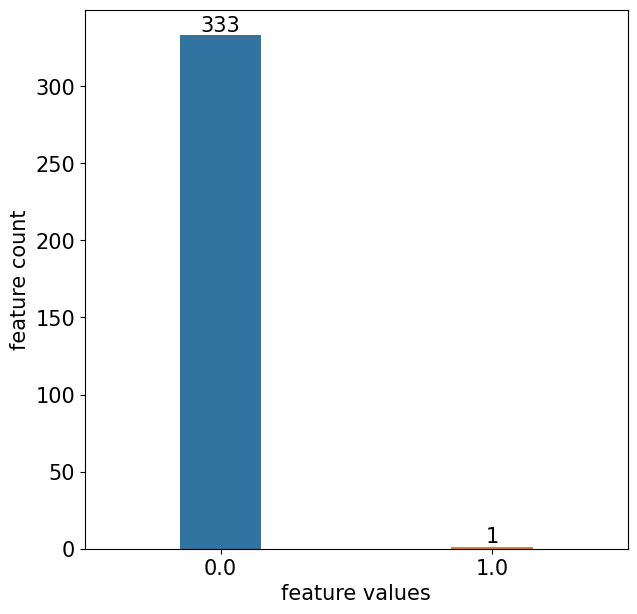

In [39]:
count_plot(list2)

Number of nodes:  26
nodeid for generating 2 hop graph:  9223
Max pred probability for class 3 is 0.9994144439697266


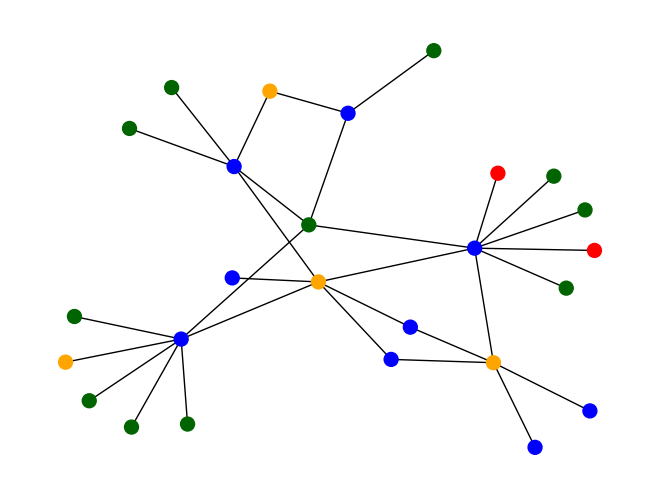

In [40]:
explanation_graph3 = plot_graph(class3_nodeid, max_pred3, 3, all_edges[class3_nodeid])

In [41]:
ind= index_2d(softmax_dict[class3_nodeid], max_pred3)[0]

list3= nodefeature_dict[class3_nodeid]['author'].numpy()[ind]

In [42]:
Counter(list3)

Counter({0.0: 326, 1.0: 8})

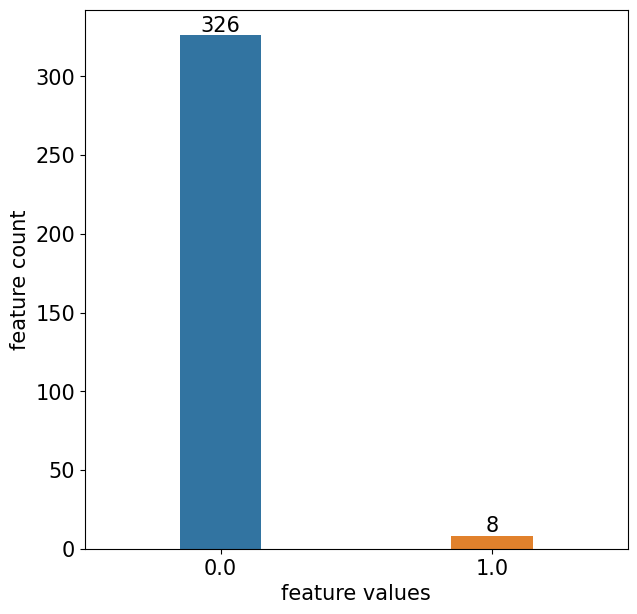

In [43]:
count_plot(list3)

In [44]:
def print_stat_cont_features(df):
    print('summary',df.describe())
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [45]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

In [46]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat

In [47]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['term'].numpy())
print_stat_cont_features(term0_df)

summary               0          1          2          3          4          5   \
count  15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
mean    0.251488   0.037883  -0.242285   0.034796   0.020150   0.184591   
std     0.587172   0.611628   0.480792   0.553586   0.521730   0.654741   
min    -0.955517  -1.240012  -0.962038  -0.826328  -0.761142  -0.988449   
25%    -0.027011  -0.213844  -0.589778  -0.356331  -0.343842  -0.178639   
50%     0.470204   0.057287  -0.315827   0.070525  -0.039120   0.139766   
75%     0.623015   0.503490   0.111391   0.434585   0.286724   0.644073   
max     0.969656   0.862203   0.606898   0.799640   0.969981   1.220626   

              6          7          8          9   ...         40         41  \
count  15.000000  15.000000  15.000000  15.000000  ...  15.000000  15.000000   
mean    0.067882  -0.158691   0.086729  -0.032436  ...   0.018961  -0.009300   
std     0.786318   0.445461   0.656104   0.636359  ...   0.546404   0.584531

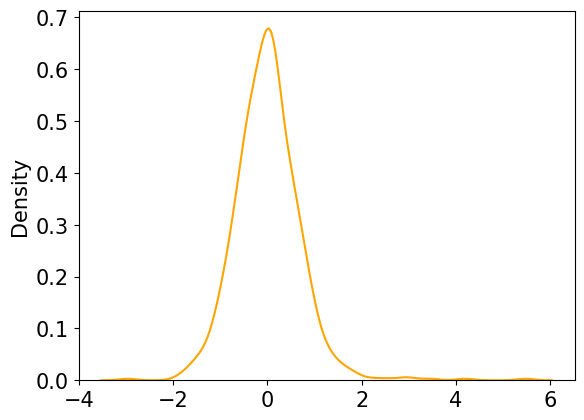

In [48]:
plot_node_feat(term0_df)

In [49]:
term1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['term'].numpy())
print_stat_cont_features(term1_df)

summary              0         1         2         3         4         5         6   \
count  7.000000  7.000000  7.000000  7.000000  7.000000  7.000000  7.000000   
mean   0.592207 -0.242537  0.122745 -0.291575  0.447656  0.099092  0.303126   
std    0.555288  0.451476  0.518914  0.445818  0.596357  0.465668  0.923941   
min    0.126707 -0.897352 -0.614503 -0.691989 -0.201550 -0.564442 -1.360506   
25%    0.211780 -0.492944 -0.260789 -0.548285 -0.126274 -0.256070 -0.100708   
50%    0.398883 -0.244808  0.317245 -0.439801  0.620810  0.193874  0.499588   
75%    0.744018 -0.024271  0.459716 -0.215723  0.843826  0.436708  0.930718   
max    1.708266  0.478833  0.758617  0.618784  1.279225  0.702936  1.322779   

             7         8         9   ...        40        41        42  \
count  7.000000  7.000000  7.000000  ...  7.000000  7.000000  7.000000   
mean  -0.278034 -0.066362  0.125821  ... -0.042767 -0.179906 -0.029078   
std    0.364571  0.559720  0.831196  ...  0.597946  0.2113

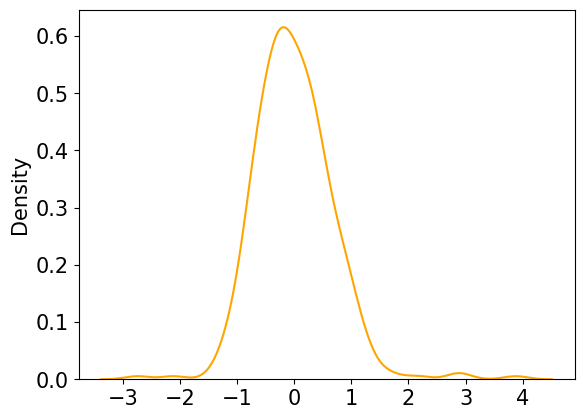

In [50]:
plot_node_feat(term1_df)

In [51]:
term2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['term'].numpy())
print_stat_cont_features(term2_df)

summary              0         1         2         3         4         5         6   \
count  9.000000  9.000000  9.000000  9.000000  9.000000  9.000000  9.000000   
mean   0.259020  0.111512 -0.322695 -0.102807  0.019606 -0.046617 -0.073302   
std    0.650997  0.399852  0.433170  0.444036  0.529131  0.451685  0.615782   
min   -0.493592 -0.397714 -0.758953 -0.657895 -0.613480 -0.696480 -0.945782   
25%   -0.293413 -0.165662 -0.538995 -0.479124 -0.467301 -0.425151 -0.568176   
50%    0.354605  0.023030 -0.423019 -0.224051 -0.038035  0.030885 -0.082966   
75%    0.691413  0.257543 -0.377109  0.359880  0.621022  0.203602  0.298545   
max    1.418480  0.895963  0.412368  0.553625  0.668683  0.675572  0.990345   

             7         8         9   ...        40        41        42  \
count  9.000000  9.000000  9.000000  ...  9.000000  9.000000  9.000000   
mean  -0.063020 -0.329524 -0.175263  ... -0.181418 -0.248545 -0.143701   
std    0.624599  0.556066  0.687632  ...  0.462602  0.4215

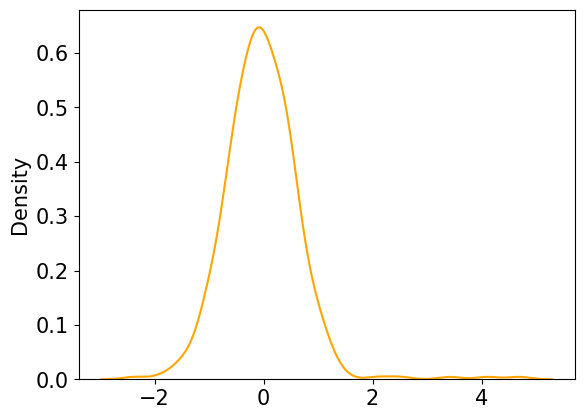

In [52]:
plot_node_feat(term2_df)

In [53]:
term3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['term'].numpy())
print_stat_cont_features(term3_df)

summary               0          1          2          3          4          5   \
count  11.000000  11.000000  11.000000  11.000000  11.000000  11.000000   
mean    0.540496  -0.209423  -0.146253   0.488860   0.118461   0.172363   
std     0.690900   0.547535   0.477217   0.290138   0.619926   0.467005   
min    -0.407317  -1.029584  -0.823639  -0.068424  -0.636502  -0.476859   
25%     0.082225  -0.593665  -0.439440   0.283915  -0.329236  -0.172816   
50%     0.378728  -0.005410  -0.279829   0.549648   0.141228   0.267149   
75%     1.122643   0.153585   0.023962   0.631325   0.409799   0.616793   
max     1.643782   0.543118   0.945601   0.991546   1.463123   0.710277   

              6          7          8          9   ...         40         41  \
count  11.000000  11.000000  11.000000  11.000000  ...  11.000000  11.000000   
mean   -0.096180  -0.169588   0.015257  -0.227288  ...  -0.070679  -0.241432   
std     0.588280   0.578707   0.323362   0.733534  ...   0.731587   0.490407

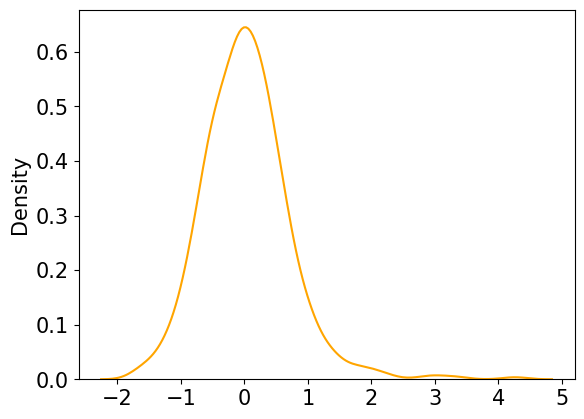

In [54]:
plot_node_feat(term3_df)

In [55]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['paper'].numpy())
paper0_df

,0,1,2,3,4,5,6,7,8,9,...,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
imp_paper_feat0=feature_selection(paper0_df)

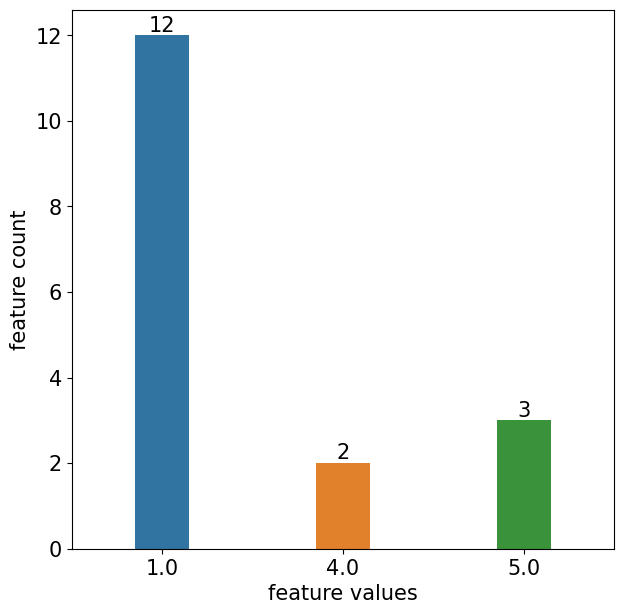

In [57]:
count_plot(imp_paper_feat0.values.tolist())

In [58]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['paper'].numpy())
paper1_df

,0,1,2,3,4,5,6,7,8,9,...,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


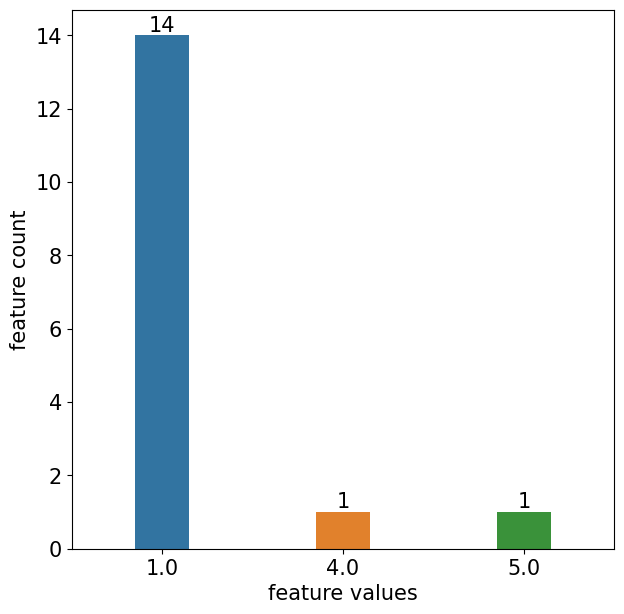

In [59]:
imp_paper_feat1=feature_selection(paper1_df)
count_plot(imp_paper_feat1.values.tolist())

In [60]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['paper'].numpy())
paper2_df

,0,1,2,3,4,5,6,7,8,9,...,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


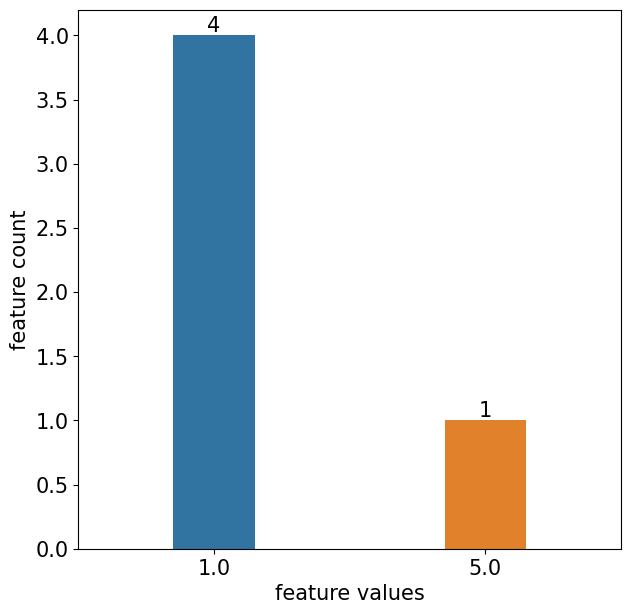

In [61]:
imp_paper_feat2=feature_selection(paper2_df)
count_plot(imp_paper_feat2.values.tolist())

In [62]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['paper'].numpy())
paper3_df

,0,1,2,3,4,5,6,7,8,9,...,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


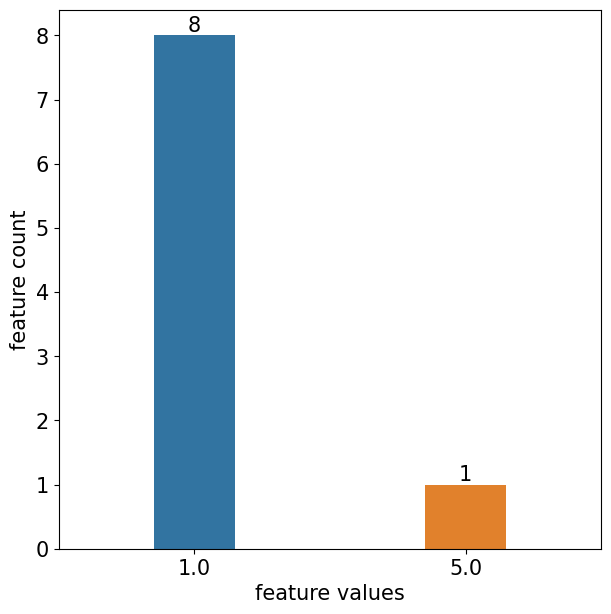

In [63]:
imp_paper_feat3=feature_selection(paper3_df)
count_plot(imp_paper_feat3.values.tolist())